C:\Users\Admin\AppData\Local\Temp\ipykernel_16740\515625340.py:191: RuntimeWarning: overflow encountered in square
  return  2*t +y**2-t**2+y_delay-(t-1)**2


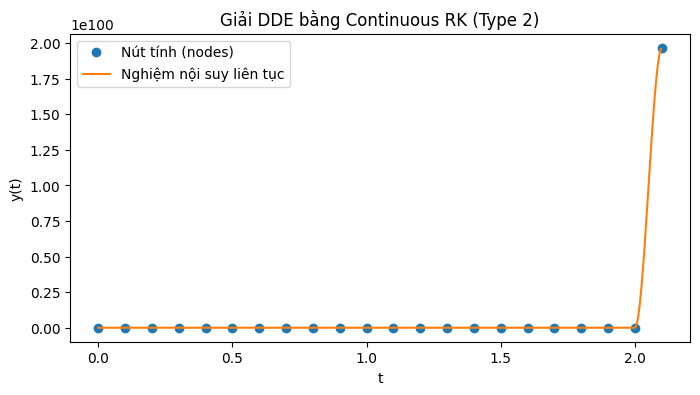

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Các hàm continuous extension cho RK4:
# Bảng Butcher của RK4:
#     c = [0, 0.5, 0.5, 1]
#     A = [[0,    0,   0, 0],
#          [0.5,  0,   0, 0],
#          [0,   0.5,  0, 0],
#          [0,    0,   1, 0]]
#     b = [1/6, 1/3, 1/3, 1/6]
# Hàm nội suy được định nghĩa dưới dạng:
#     eta(t_n+theta*h) = y_n + h * sum_{i=1}^{4} b_i_cont(theta) * k_i,
# với b_i_cont(theta) = H(theta)*b_i, trong đó H(theta)=theta^2*(3-2*theta)
# ---------------------------

def H(theta):
    """Hàm nội suy cubic: H(0)=0, H(1)=1."""
    return theta**2 * (3 - 2*theta)

# Continuous extension coefficients:
def b1_cont(theta):
    return (1/6) * H(theta)

def b2_cont(theta):
    return (1/3) * H(theta)

def b3_cont(theta):
    return (1/3) * H(theta)

def b4_cont(theta):
    return (1/6) * H(theta)

# ---------------------------
# DDE Solver sử dụng Continuous RK (Type 2) với RK4
# ---------------------------
class DDE_RK_Solver:
    def __init__(self, f, tau, phi, t0, tf, h, tol=1e-6):
        """
        f: hàm f(t, y, y_delay)
        tau: hàm tau(t, y)
        phi: hàm history, định nghĩa cho t <= t0
        t0: thời điểm bắt đầu
        tf: thời điểm kết thúc
        h: bước thời gian (có thể điều chỉnh theo các ước lượng Lipschitz)
        tol: ngưỡng sai số (nếu cần adaptive bước)
        """
        self.f = f
        self.tau = tau
        self.phi = phi
        self.t0 = t0
        self.tf = tf
        self.h = h
        self.tol = tol
        # Lưu trữ các bước tính: mỗi bước là một dict gồm thông tin cần thiết
        self.steps = []  
        # Lưu trữ điểm thời gian và giá trị y tại các nút
        self.solution_t = []
        self.solution_y = []
    
    def get_history(self, t):
        """Trả về giá trị của y tại thời điểm t, dùng phi(t) nếu t <= t0."""
        if t <= self.t0:
            return self.phi(t)
        else:
            return self.interpolate(t)
    
    def interpolate(self, t):
        """
        Nếu t > t0, tìm bước tính mà t nằm trong [t_n, t_{n+1}],
        sau đó sử dụng hàm nội suy của bước đó.
        """
        for step in self.steps:
            if step['t_n'] <= t <= step['t_np1']:
                theta = (t - step['t_n']) / step['h']
                return step['interp'](theta)
        # Nếu không tìm được (ví dụ t > t_f), trả về giá trị tại bước cuối cùng.
        return self.steps[-1]['y_np1']
    
    def solve(self):
        """Chạy giải thuật và trả về mảng thời gian và nghiệm tại các nút."""
        t = self.t0
        y = self.phi(self.t0)  # giá trị ban đầu tại t0
        self.solution_t.append(t)
        self.solution_y.append(y)
        
        while t < self.tf:
            h = self.h
            # Nếu bước cuối vượt quá tf thì điều chỉnh h
            if t + h > self.tf:
                h = self.tf - t
            
            # ---------------------------
            # Tính các stage của RK4
            # ---------------------------
            # Stage 1:
            t1 = t
            Y1 = y  # vì a_{1j}=0
            # Tính giá trị trễ cho stage 1:
            t_delay = t1 - self.tau(t1, Y1)
            if t_delay <= self.t0:
                y_delay = self.phi(t_delay)
            else:
                y_delay = self.interpolate(t_delay)
            k1 = self.f(t1, Y1, y_delay)
            
            # Stage 2:
            t2 = t + 0.5 * h
            Y2 = y + 0.5 * h * k1
            t_delay = t2 - self.tau(t2, Y2)
            if t_delay <= self.t0:
                y_delay = self.phi(t_delay)
            else:
                y_delay = self.interpolate(t_delay)
            k2 = self.f(t2, Y2, y_delay)
            
            # Stage 3:
            t3 = t + 0.5 * h
            Y3 = y + 0.5 * h * k2
            t_delay = t3 - self.tau(t3, Y3)
            if t_delay <= self.t0:
                y_delay = self.phi(t_delay)
            else:
                y_delay = self.interpolate(t_delay)
            k3 = self.f(t3, Y3, y_delay)
            
            # Stage 4:
            t4 = t + h
            Y4 = y + h * k3
            t_delay = t4 - self.tau(t4, Y4)
            if t_delay <= self.t0:
                y_delay = self.phi(t_delay)
            else:
                y_delay = self.interpolate(t_delay)
            k4 = self.f(t4, Y4, y_delay)
            
            # ---------------------------
            # Cập nhật nghiệm tại t+h theo RK4
            # ---------------------------
            y_np1 = y + h * ( (1/6)*k1 + (1/3)*k2 + (1/3)*k3 + (1/6)*k4 )
            
            # ---------------------------
            # Xây dựng hàm nội suy liên tục trên bước [t, t+h]
            # Sử dụng continuous extension: 
            #   eta(theta) = y + h * [b1_cont(theta)*k1 + b2_cont(theta)*k2 + b3_cont(theta)*k3 + b4_cont(theta)*k4]
            # với theta in [0,1]
            # ---------------------------
            def interp(theta, y=y, h=h, k1=k1, k2=k2, k3=k3, k4=k4):
                return y + h * ( b1_cont(theta)*k1 + b2_cont(theta)*k2 + b3_cont(theta)*k3 + b4_cont(theta)*k4 )
            
            # Lưu thông tin bước vừa tính
            step_info = {
                't_n': t,
                't_np1': t + h,
                'h': h,
                'y_n': y,
                'y_np1': y_np1,
                'interp': interp
            }
            self.steps.append(step_info)
            
            # Cập nhật danh sách nghiệm tại các nút
            t = t + h
            y = y_np1
            self.solution_t.append(t)
            self.solution_y.append(y)
        
        return np.array(self.solution_t), np.array(self.solution_y)
    
    def evaluate(self, t_query):
        """
        Trả về giá trị ước lượng y(t_query) bằng cách sử dụng hàm nội suy tương ứng.
        Nếu t_query <= t0 thì sử dụng hàm lịch sử phi.
        """
        if t_query <= self.t0:
            return self.phi(t_query)
        else:
            return self.interpolate(t_query)

# ---------------------------
# Ví dụ sử dụng solver
# ---------------------------
if __name__ == "__main__":
    # Ví dụ: giải một DDE đơn giản
    # Ta định nghĩa f, tau, và phi.
    # Ở đây, ta xem y là giá trị vô hướng.
    
    def f_example(t, y, y_delay):
        # ví dụ đơn giản: y, y_delay là mảng 1D shape=(1,)
        return  2*t +y**2-t**2+y_delay-(t-1)**2
    
    def tau_example(t, y):
        # trễ = 1 + (y[0] - e^t)^2
        return 1
    
    def phi_example(t):
        # hàm lịch sử, e^t
        return np.array([t**2])
    
    t0 = 0.0
    tf = 6.0
    h = 0.1  # bước thời gian (có thể điều chỉnh theo các ước lượng Lipschitz)
    
    solver = DDE_RK_Solver(f_example, tau_example, phi_example, t0, tf, h)
    ts, ys = solver.solve()
    
    # Vẽ đồ thị nghiệm tại các nút và một vài nội suy trung gian
    t_dense = np.linspace(t0, tf, 1000)
    y_dense = np.array([solver.evaluate(t_val) for t_val in t_dense])
    
    plt.figure(figsize=(8, 4))
    plt.plot(ts, ys, 'o', label='Nút tính (nodes)')
    plt.plot(t_dense, y_dense, '-', label='Nghiệm nội suy liên tục')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.legend()
    plt.title("Giải DDE bằng Continuous RK (Type 2)")
    plt.show()


In [74]:
abs(ys[-1]-y_exact(6))/y_exact(6)

np.float64(0.26608886791084174)

[a_0_0*θ + a_0_1*θ**2 + a_0_2*θ**3 + a_0_3*θ**4,
 a_1_0*θ + a_1_1*θ**2 + a_1_2*θ**3 + a_1_3*θ**4,
 a_2_0*θ + a_2_1*θ**2 + a_2_2*θ**3 + a_2_3*θ**4,
 a_3_0*θ + a_3_1*θ**2 + a_3_2*θ**3 + a_3_3*θ**4,
 a_4_0*θ + a_4_1*θ**2 + a_4_2*θ**3 + a_4_3*θ**4,
 a_5_0*θ + a_5_1*θ**2 + a_5_2*θ**3 + a_5_3*θ**4]

In [51]:
h_values = np.diff(ts)
h_min = np.min(h_values)
h_max = np.max(h_values)
h_max, h_min, len(ts)

(np.float64(0.10000000000000009), np.float64(5.329070518200751e-15), 62)

Bước từ t=0.95047 với h=1.44020e-01 bị từ chối, error=2.307e-05. Giảm bước xuống h=1.440e-01.
Bước từ t=0.95047 với h=1.18000e-01 bị từ chối, error=1.599e-05. Giảm bước xuống h=1.180e-01.
Bước từ t=1.06847 với h=7.42626e-02 bị từ chối, error=7.020e-04. Giảm bước xuống h=7.426e-02.
Bước từ t=1.14273 với h=7.00014e-02 bị từ chối, error=2.202e-05. Giảm bước xuống h=7.000e-02.
Bước từ t=1.21274 với h=5.47575e-02 bị từ chối, error=3.915e-05. Giảm bước xuống h=5.476e-02.
Bước từ t=1.21274 với h=3.97065e-02 bị từ chối, error=2.945e-05. Giảm bước xuống h=3.971e-02.
Bước từ t=1.21274 với h=3.35626e-02 bị từ chối, error=1.369e-05. Giảm bước xuống h=3.356e-02.
Bước từ t=1.27965 với h=4.35657e-02 bị từ chối, error=8.034e-05. Giảm bước xuống h=4.357e-02.
Bước từ t=1.27965 với h=3.55032e-02 bị từ chối, error=1.643e-05. Giảm bước xuống h=3.550e-02.
Bước từ t=1.36538 với h=4.46106e-02 bị từ chối, error=4.938e-05. Giảm bước xuống h=4.461e-02.
Bước từ t=1.36538 với h=3.34444e-02 bị từ chối, error=2.493e

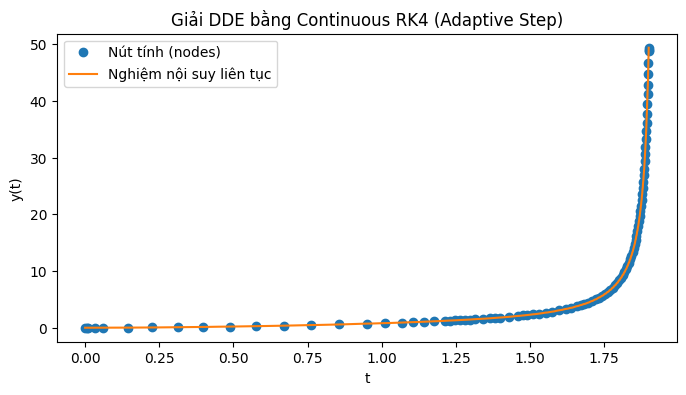

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Hàm nội suy cubic cho continuous extension
def H(theta):
    """Hàm nội suy cubic: H(0)=0, H(1)=1."""
    return theta**2 * (3 - 2*theta)

# Định nghĩa các hàm continuous extension coefficients cho RK4
def b1_cont(theta):
    return (1/6) * H(theta)

def b2_cont(theta):
    return (1/3) * H(theta)

def b3_cont(theta):
    return (1/3) * H(theta)

def b4_cont(theta):
    return (1/6) * H(theta)

# ---------------------------
# Solver DDE với RK4, continuous extension loại 2, và bước thích nghi
# ---------------------------
class DDE_RK_AdaptiveSolver:
    def __init__(self, f, tau, phi, t0, tf, h_init, tol=1e-6, safety=0.9):
        """
        f: hàm f(t, y, y_delay)
        tau: hàm tau(t, y)
        phi: hàm lịch sử, định nghĩa cho t <= t0
        t0, tf: khoảng thời gian giải [t0, tf]
        h_init: bước thời gian khởi đầu
        tol: ngưỡng sai số để điều chỉnh bước
        safety: hệ số an toàn khi cập nhật bước
        """
        self.f = f
        self.tau = tau
        self.phi = phi
        self.t0 = t0
        self.tf = tf
        self.h = h_init
        self.tol = tol
        self.safety = safety
        
        # Danh sách lưu trữ các bước (mỗi bước là một dict chứa thông tin bước)
        self.steps = []
        self.solution_t = []
        self.solution_y = []
    
    def get_history(self, t):
        """Trả về giá trị của y tại thời điểm t.
           Nếu t <= t0, dùng hàm lịch sử phi, còn nếu t > t0, dùng nội suy từ các bước đã lưu."""
        if t <= self.t0:
            return self.phi(t)
        else:
            return self.interpolate(t)
    
    def interpolate(self, t):
        """
        Tìm bước có chứa t và sử dụng hàm nội suy của bước đó.
        Nếu không tìm thấy (t > tf), trả về y của bước cuối cùng.
        """
        for step in self.steps:
            if step['t_n'] <= t <= step['t_np1']:
                theta = (t - step['t_n']) / step['h']
                return step['interp'](theta)
        return self.steps[-1]['y_np1']
    
    def single_RK4_step(self, t, y, h):
        """
        Tính một bước RK4 với bước h từ (t, y) và trả về thông tin bước.
        Bao gồm: t_n, t_np1, h, y_n, y_np1, và hàm nội suy liên tục interp(theta).
        Xử lý đối số trễ: nếu thời điểm trễ <= t0, sử dụng phi, còn lại nội suy.
        """
        # Stage 1:
        t1 = t
        Y1 = y
        t_delay = t1 - self.tau(t1, Y1)
        if t_delay <= self.t0:
            y_delay = self.phi(t_delay)
        else:
            y_delay = self.interpolate(t_delay)
        k1 = self.f(t1, Y1, y_delay)
        
        # Stage 2:
        t2 = t + 0.5 * h
        Y2 = y + 0.5 * h * k1
        t_delay = t2 - self.tau(t2, Y2)
        if t_delay <= self.t0:
            y_delay = self.phi(t_delay)
        else:
            y_delay = self.interpolate(t_delay)
        k2 = self.f(t2, Y2, y_delay)
        
        # Stage 3:
        t3 = t + 0.5 * h
        Y3 = y + 0.5 * h * k2
        t_delay = t3 - self.tau(t3, Y3)
        if t_delay <= self.t0:
            y_delay = self.phi(t_delay)
        else:
            y_delay = self.interpolate(t_delay)
        k3 = self.f(t3, Y3, y_delay)
        
        # Stage 4:
        t4 = t + h
        Y4 = y + h * k3
        t_delay = t4 - self.tau(t4, Y4)
        if t_delay <= self.t0:
            y_delay = self.phi(t_delay)
        else:
            y_delay = self.interpolate(t_delay)
        k4 = self.f(t4, Y4, y_delay)
        
        # Tính y tại t+h theo RK4
        y_np1 = y + h * ((1/6)*k1 + (1/3)*k2 + (1/3)*k3 + (1/6)*k4)
        
        # Xây dựng hàm nội suy liên tục trên [t, t+h]
        def interp(theta, y=y, h=h, k1=k1, k2=k2, k3=k3, k4=k4):
            return y + h * (b1_cont(theta)*k1 + b2_cont(theta)*k2 + b3_cont(theta)*k3 + b4_cont(theta)*k4)
        
        step_info = {
            't_n': t,
            't_np1': t + h,
            'h': h,
            'y_n': y,
            'y_np1': y_np1,
            'interp': interp
        }
        return step_info

    def step_doubling(self, t, y, h):
        """
        Tính bước với kích thước h và ước lượng sai số qua phương pháp step doubling.
        Trả về:
         - accepted: True/False
         - steps: danh sách các bước đã tính (nếu accepted, sẽ gồm 2 bước nhỏ)
         - error: ước lượng sai số (norm(y_full - y_two_half))
         - y_full: nghiệm theo full step
         - y_two_half: nghiệm sau 2 bước h/2
        """
        # Tính full step
        step_full = self.single_RK4_step(t, y, h)
        y_full = step_full['y_np1']
        
        # Tính 2 bước với h/2
        h_half = h/2
        step_half1 = self.single_RK4_step(t, y, h_half)
        t_mid = t + h_half
        y_mid = step_half1['y_np1']
        step_half2 = self.single_RK4_step(t_mid, y_mid, h_half)
        y_two_half = step_half2['y_np1']
        
        error = np.linalg.norm(y_two_half - y_full)
        steps = [step_half1, step_half2]
        return error, y_full, y_two_half, steps

    def solve(self):
        """
        Tích hợp DDE trên [t0, tf] với bước thích nghi.
        Các bước được lưu vào self.steps, và các nút (solution_t, solution_y) cũng được lưu.
        """
        t = self.t0
        y = self.phi(self.t0)
        self.solution_t.append(t)
        self.solution_y.append(y)
        
        h = self.h
        # Giá trị thứ tự của phương pháp RK4: order = 4 (local truncation error O(h^5))
        order = 4
        
        while t < self.tf:
            # Nếu bước vượt quá tf thì điều chỉnh
            if t + h > self.tf:
                h = self.tf - t

            # Thực hiện step doubling để ước lượng sai số
            error, y_full, y_two_half, steps_candidate = self.step_doubling(t, y, h)
            
            # Quy tắc cập nhật bước: nếu sai số <= tol, chấp nhận bước
            if error <= self.tol:
                # Chấp nhận hai bước h/2
                for step in steps_candidate:
                    self.steps.append(step)
                    self.solution_t.append(step['t_np1'])
                    self.solution_y.append(step['y_np1'])
                t = t + h
                y = y_two_half
                # Cập nhật bước h theo công thức điều chỉnh
                if error == 0:
                    h_new = h * 2
                else:
                    h_new = h * self.safety * (self.tol / error)**(1/(order+1))
                # Giới hạn thay đổi bước để tránh thay đổi đột ngột
                h = min(max(0.1 * h, h_new), 5.0 * h)
            else:
                # Nếu sai số quá lớn, giảm bước và tính lại
                h_new = h * self.safety * (self.tol / error)**(1/(order+1))
                h = max(0.1 * h, h_new)
                # Bước bị loại bỏ, không cập nhật t, y.
                # In thông tin để debug (nếu cần):
                print(f"Bước từ t={t:.5f} với h={h:.5e} bị từ chối, error={error:.3e}. Giảm bước xuống h={h_new:.3e}.")
        
        return np.array(self.solution_t), np.array(self.solution_y)
    
    def evaluate(self, t_query):
        """
        Trả về giá trị ước lượng y(t_query) dựa vào nội suy.
        Nếu t_query <= t0, dùng phi; nếu không, tìm bước chứa t_query.
        """
        if t_query <= self.t0:
            return self.phi(t_query)
        else:
            return self.interpolate(t_query)

# ---------------------------
# Ví dụ sử dụng solver với adaptive step size
# ---------------------------
if __name__ == "__main__":
    # Ví dụ: giải DDE đơn giản
    # Phương trình: y'(t) = -y(t) + y(t - tau)
    # Với tau(t, y) = 0.5 (không phụ thuộc vào y) và hàm lịch sử phi(t) = 1, t <= 0.
    
    def f_example(t, y, y_delay):
        return 2*t +y**2-t**2+y_delay-(t-1)**2

    def tau_example(t, y):
        # Delay hằng số
        return 1

    def phi_example(t):
        # Hàm lịch sử, giả sử là hàm mũ trên t<=t0
        return t**2
    
    t0 = 0.0
    tf = 1.9
    h_init = 0.01
    tol = 1e-5  # ngưỡng sai số cho bước thích nghi
    
    solver = DDE_RK_AdaptiveSolver(f_example, tau_example, phi_example, t0, tf, h_init, tol=tol)
    ts, ys = solver.solve()
    
    # Tạo đồ thị nghiệm (nút và nội suy)
    t_dense = np.linspace(t0, tf, 2000)
    y_dense = np.array([solver.evaluate(t_val) for t_val in t_dense])
    
    plt.figure(figsize=(8, 4))
    plt.plot(ts, ys, 'o', label='Nút tính (nodes)')
    plt.plot(t_dense, y_dense, '-', label='Nghiệm nội suy liên tục')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.legend()
    plt.title("Giải DDE bằng Continuous RK4 (Adaptive Step)")
    plt.show()


In [4]:
h_values = np.diff(ts)
h_min = np.min(h_values)
h_max = np.max(h_values)
h_max, h_min, len(ts)

(np.float64(0.03222195556419688), np.float64(0.0005014208885114613), 2971)

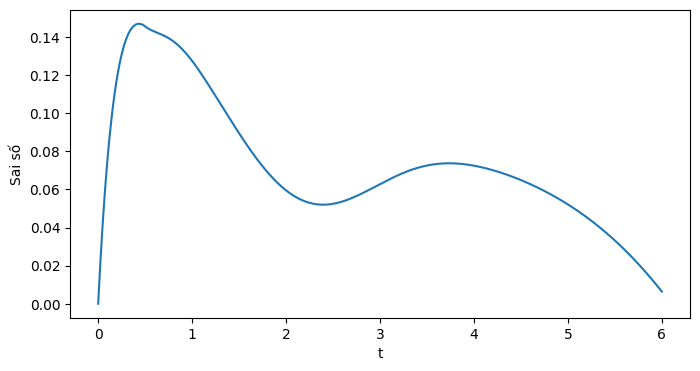

In [3]:
def y_exact(t):
    return 1/(1+t)
#tính sai số
error = np.abs(ys - y_exact(ts))
#vẽ đồ thị sai số
plt.figure(figsize=(8, 4))
plt.plot(ts, error, label='Sai số')
plt.xlabel('t')
plt.ylabel('Sai số')

plt.show()

In [4]:
# cerk6_find_new_table.py  –  Option 2: eliminate β, solve for A,B,C
import sympy as sp, random, itertools

# ------------------------------------------------------------------
# 0.  Cài đặt chung
s, p = 6, 4                      # 6 stage, đa thức β bậc 4
theta = sp.symbols('theta')

# ------------------------------------------------------------------
# 1.  Khởi tạo ẩn ---------------------------------------------------
#  (1)  c  –  lấy sẵn dạng đều để thu hẹp ẩn, nhưng **vẫn cho phép
#            trôi nhẹ** bằng cách thêm ∆c_i bé:   c_i = i/5 + δ_i
c_free  = sp.symbols('dc2:7')                 # δ₂..δ₆
c       = [sp.Integer(0)] + \
          [sp.Rational(i, 5) + c_free[i-1] for i in range(1, 6)]

#  (2)  a_ij (j<i)
a = {(i, j): sp.symbols(f'a{i}{j}') for i in range(2, s+1)
                                      for j in range(1, i)}

#  (3)  b_i
b = sp.symbols('b1:7')

# ------------------------------------------------------------------
# 2.  Ẩn tuyến tính β_{ik}
beta = {(i, k): sp.symbols(f"beta{i}_{k}")
        for i in range(1, s+1) for k in range(1, p+1)}

def btheta(i):
    return sum(beta[i, k]*theta**k for k in range(1, p+1))

def tc(expr, k):                 # lấy hệ số θ^k
    return sp.Poly(sp.expand(expr), theta).coeff_monomial(theta**k)

# ------------------------------------------------------------------
# 3.  Xây toàn bộ hệ phương trình
eqs = []

# ---- 3·1  row‑sum  (giữ explicit)
for i in range(2, s+1):
    eqs.append(sum(a[i, j] for j in range(1, i)) - c[i-1])

# ---- 3·2  discrete order 4
eqs += [
    sum(b) - 1,
    sum(b[i]*c[i]      for i in range(s)) - sp.Rational(1, 2),
    sum(b[i]*c[i]**2   for i in range(s)) - sp.Rational(1, 3),
    sum(b[i]*c[i]**3   for i in range(s)) - sp.Rational(1, 4),
    sum(b[i]*a[i+1, j+1]*c[j] for i in range(1, s) for j in range(i))
        - sp.Rational(1, 6)
]

# ---- 3·3  continuous conditions (8 khối)
cont_targets = {1: (1, 0, 0, 0),                # θ
                2: (0, sp.Rational(1,2), 0, 0), # θ²/2
                3: (0, 0, sp.Rational(1,3), 0), # θ³/3
                4: (0, 0, sp.Rational(1,6), 0), # θ³/6
                5: (0, 0, 0, sp.Rational(1,4)), # θ⁴/4
                6: (0, 0, 0, sp.Rational(1,8)), # θ⁴/8
                7: (0, 0, 0, sp.Rational(1,12)),# θ⁴/12
                8: (0, 0, 0, sp.Rational(1,24)) }# θ⁴/24

# helper to append 4 phương trình ứng với 1 biểu thức
def add_block(expr, tag):
    tgt = cont_targets[tag]
    eqs.extend(tc(expr, k+1) - tgt[k] for k in range(4))

# khối (1) … (4)
add_block(sum(btheta(i) for i in range(1, s+1)), 1)
add_block(sum(btheta(i)*c[i-1]        for i in range(1, s+1)), 2)
add_block(sum(btheta(i)*c[i-1]**2     for i in range(1, s+1)), 3)
add_block(sum(btheta(i)*a[i, j]*c[j-1]
              for i in range(2, s+1) for j in range(1, i)),       4)
# khối (5) … (8)
S1 = sum(btheta(i)*c[i-1]**3                 for i in range(1, s+1))
S2 = sum(btheta(i)*c[i-1]*a[i, j]*c[j-1]     for i in range(2, s+1) for j in range(1, i))
S3 = sum(btheta(i)*a[i, j]*c[j-1]**2         for i in range(2, s+1) for j in range(1, i))
S4 = sum(btheta(i)*a[i, j]*sum(a[j, k]*c[k-1] for k in range(1, j))
         for i in range(2, s+1) for j in range(1, i))
for expr, tag in zip((S1, S2, S3, S4), (5, 6, 7, 8)):
    add_block(expr, tag)

# ------------------------------------------------------------------
# 4.  LOẠI β  (hệ tuyến tính theo β)
beta_syms = [beta[i, k] for i in range(1, s+1) for k in range(1, p+1)]
M, rhs    = sp.linear_eq_to_matrix(eqs, beta_syms)   # 46×24  (β) = rhs
beta_sol  = M.gauss_jordan_solve(rhs)[0]             # β biểu diễn theo A,B,C

# ------------------------------------------------------------------
# 5.  Hệ phi‑tuyến còn lại (thế β_sol rồi rút gọn)
beta_dict = dict(zip(beta_syms, beta_sol))
eqs_reduced = [sp.simplify(eq.subs(beta_dict))        # kq phải = 0
               for eq in eqs if any(sym not in beta_syms for sym in eq.free_symbols)]

unknowns =  (list(a.values()) + list(b) + list(c_free))   # 15+6+5 = 26

# ------------------------------------------------------------------
# 6.  Điểm khởi tạo cho nsolve  ------------------------------
seed = 0.1
start = [seed*(random.random()-0.5) for _ in unknowns]   # số nhỏ quanh 0

# ------------------------------------------------------------------
# 7.  Giải
print("Đang chạy nsolve … (có thể mất vài chục giây)")
sol_num = sp.nsolve(eqs_reduced, unknowns, start,
                    tol=1e-13, maxsteps=100)

print("\n✓ Tìm được bảng mới!")

# ------------------------------------------------------------------
# 8.  Kết quả Butcher tableau + đa thức β(θ)
A_num = sp.zeros(s, s)
k = 0
for i in range(2, s+1):
    for j in range(1, i):
        A_num[i-1, j-1] = sol_num[k]; k += 1
b_num = sol_num[k:k+6]; k += 6
dc    = sol_num[k:]
c_num = [0] + [sp.Rational(i,5)+dc[i-1] for i in range(1,6)]

# đa thức β
β_num = []
for (i, kβ), expr in zip(beta_syms, beta_sol.subs(dict(zip(unknowns, sol_num)))):
    β_num.append(expr)
β_mat = sp.Matrix(s, p, β_num)

# --------------------- in đẹp -------------------------------
print("\nButcher tableau (c|A):")
for i in range(s):
    row = " ".join(f"{float(A_num[i,j]):>11.8f}" if j<i else " "*12
                   for j in range(s))
    print(f"{float(c_num[i]):>6.3f} | {row}")
print("          " + "-"*12*s)
print("            " + " ".join(f"{float(val):>11.8f}" for val in b_num))

print("\nβ‑polynomials:")
tt = sp.symbols('θ')
for i in range(s):
    poly = sum(β_mat[i, k]*tt**(k+1) for k in range(p))
    print(f"b_{i+1}(θ) =", sp.simplify(poly))


KeyboardInterrupt: 